In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from ase.db import connect
import schnetpack

database_path = "C:/Users/Yakov/Documents/_notebooks/juniper_notebooks/Task3_Qant/train.db"  # Путь к файлу базы данных
dataset = schnetpack.data.AtomsData(database_path)

In [3]:
print('Number of reference calculations:', len(dataset))
print('Available properties:')

for p in dataset.available_properties:
    print('-', p)

Number of reference calculations: 138365
Available properties:
- energy


In [4]:
example = dataset[0]
print('Properties:')

for k, v in example.items():
    print('-', k, ':', v.shape)

Properties:
- energy : torch.Size([1])
- _atomic_numbers : torch.Size([44])
- _positions : torch.Size([44, 3])
- _neighbors : torch.Size([44, 43])
- _cell : torch.Size([3, 3])
- _cell_offset : torch.Size([44, 43, 3])
- _idx : torch.Size([1])


In [5]:
at = dataset.get_atoms(idx=0)
print('Atoms object:', at)

at2, props = dataset.get_properties(idx=0)

Atoms object: Atoms(symbols='C4SCNC3ONCONCNC7H20', pbc=False)


In [6]:
print('Total energy at 0K:', props['energy'])

Total energy at 0K: [-1426.323]


In [7]:
train, val, test = schnetpack.train_test_split(
        data=dataset,
        num_train=len(dataset)*0.8,
        num_val=len(dataset)*0.2,
        split_file=("split.npz"),
    )

In [8]:
train_loader = schnetpack.AtomsLoader(train, batch_size=100, shuffle=True)
val_loader = schnetpack.AtomsLoader(val, batch_size=100)

In [9]:
atomrefs = dataset.get_atomref('energy')
means, stddevs = train_loader.get_statistics(
    'energy', divide_by_atoms=True, single_atom_ref=atomrefs
)
print('Mean atomization energy / atom:', means['energy'])
print('Std. dev. atomization energy / atom:', stddevs['energy'])

Mean atomization energy / atom: tensor([-30.5628])
Std. dev. atomization energy / atom: tensor([11.7278])


In [10]:
schnet = schnetpack.representation.SchNet(
    n_atom_basis=30, n_filters=30, n_gaussians=20, n_interactions=5,
    cutoff=4., cutoff_network=schnetpack.nn.cutoff.CosineCutoff
)

output_U0 = schnetpack.atomistic.Atomwise(n_in=30, atomref=atomrefs['energy'], property='energy',
                                   mean=means['energy'], stddev=stddevs['energy'])
model = schnetpack.AtomisticModel(representation=schnet, output_modules=output_U0)

In [11]:
from torch.optim import Adam

# loss function
def mse_loss(batch, result):
    diff = batch['energy']-result['energy']
    err_sq = torch.mean(diff ** 2)
    return err_sq

# build optimizer
optimizer = Adam(model.parameters(), lr=0.01)

In [12]:
model.parameters()

<generator object Module.parameters at 0x0000013FBD063510>

In [13]:
# before setting up the trainer, remove previous training checkpoints and logs
#%rm -r ./qm9tut/checkpoints
#%rm -r ./qm9tut/log.csv

import schnetpack.train as trn
qm9tut = "C:/Users/Yakov/Documents/_notebooks/juniper_notebooks/Task3_Qant/logs"
loss = trn.build_mse_loss(['energy'])

metrics = [schnetpack.metrics.MeanAbsoluteError('energy')]
hooks = [
    trn.CSVHook(log_path=qm9tut, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=5, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]

trainer = trn.Trainer(
    model_path=qm9tut,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

In [14]:
device = "cuda" # change to 'cpu' if gpu is not available
n_epochs = 1000 # takes about 10 min on a notebook GPU. reduces for playing around
trainer.train(device=device, n_epochs=n_epochs)

Final validation MAE: 0.59 eV = 13.63 kcal/mol


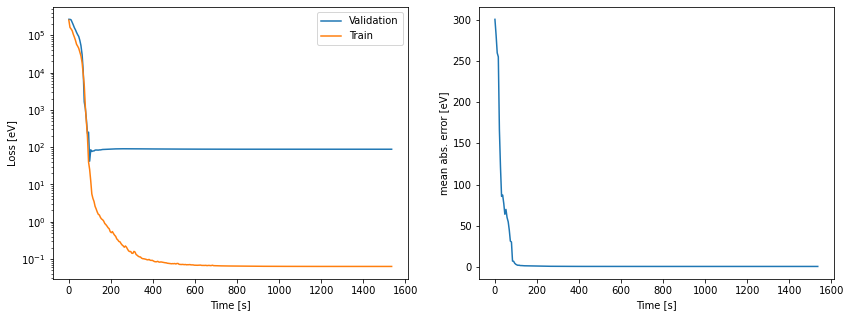

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
from ase.units import kcal, mol
qm9tut = "C:/Users/Yakov/Documents/_notebooks/juniper_notebooks/Task3_Qant/logs"
results = np.loadtxt(os.path.join(qm9tut, 'log.csv'), skiprows=1, delimiter=',')

time = results[:,0]-results[0,0]
learning_rate = results[:,1]
train_loss = results[:,2]
val_loss = results[:,3]
val_mae = results[:,4]

print('Final validation MAE:', np.round(val_mae[-1], 2), 'eV =',
      np.round(val_mae[-1] / (kcal/mol), 2), 'kcal/mol')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(time, val_loss, label='Validation')
plt.plot(time, train_loss, label='Train')
plt.yscale('log')
plt.ylabel('Loss [eV]')
plt.xlabel('Time [s]')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time, val_mae)
plt.ylabel('mean abs. error [eV]')
plt.xlabel('Time [s]')
plt.show()

In [16]:
import torch

qm9tut = "C:/Users/Yakov/Documents/_notebooks/juniper_notebooks/Task3_Qant/logs"
best_model = torch.load(os.path.join(qm9tut, 'best_model'))

#test_loader = spk.AtomsLoader(test, batch_size=100)
test_path = "C:/Users/Yakov/Documents/_notebooks/juniper_notebooks/Task3_Qant/test.db" 
test_data = schnetpack.data.AtomsData(test_path)
test_loader = schnetpack.AtomsLoader(test_data, batch_size=1)


y_pred = []
counter = []
err = 0
i=1
print(len(test_loader))
for count, batch in enumerate(test_loader):
    
    batch = {k: v.to(device) for k, v in batch.items()}

    # apply model
    pred = best_model(batch)
    
    counter.append(i)
    y_pred.append(pred['energy'].cpu().detach().numpy()[0][0])    
   
    # log progress
    percent = '{:3.2f}'.format(count/len(test_loader)*100)
    print('Progress:', percent+'%'+' '*(5-len(percent)), end="\r")
    i = i+1 
#err /= len(test)
#print('Test MAE', np.round(err, 2), 'eV =',
#      np.round(err / (kcal/mol), 2), 'kcal/mol')

70905


In [17]:
import pandas as pd
sub = pd.read_csv('C:/Users/Yakov/Documents/_notebooks/juniper_notebooks/Task3_Qant/sample_submission.csv',index_col = 'id')
sub['energy'] = y_pred
sub.to_csv('submission_1.csv')

In [18]:
mae -0.07

NameError: name 'mae' is not defined